In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npl
from numpy import inf
from tqdm.notebook import tqdm

sys.path.append("../src")

from data_utils.synthetic_data_utils import data_type_dict

In [2]:
def fit_least_squares_estimator(
    x_arr: np.ndarray, y_vec: np.ndarray, lamb: float = 0.0
) -> np.ndarray:
    """
    Fit least squares estimator
    :param x_arr: The training set features matrix. Each row represents an example.
    :param y_vec: the labels vector.
    :param lamb: regularization term.
    :return: the fitted parameters. A column vector
    """
    n, m = x_arr.shape
    phi_t_phi_plus_lamb = x_arr.T @ x_arr + lamb * np.eye(m)

    # If invertible, regular least squares
    inv = npl.inv(phi_t_phi_plus_lamb)
    theta = inv @ x_arr.T @ y_vec

    theta = np.expand_dims(theta, 1)
    return theta

In [3]:
model_degree = 6
x_test_max = 1.0
x_test_min = -1.0
dx_test = 0.01
x_train = [-0.7, -0.6, 0.05, 0.1, 0.25, 0.3, 0.35, 0.5, 0.55, 0.6]
y_train = [-0.1, -0.2, -2.0, -1.0, -0.5, -0.3, 0.1, 0.5, 0.2, 0.1]
data_type = "polynomial"
lamb = 0

In [4]:
# Create trainset
data_class = data_type_dict[data_type]
data_h = data_class(x_train, y_train, model_degree)

# Execute x_test
x_test_list = np.arange(x_test_min, x_test_max, dx_test).round(3)

theta_erm = fit_least_squares_estimator(data_h.phi_train, y_train)
theta_lamb = fit_least_squares_estimator(data_h.phi_train, y_train, lamb=lamb)
y_hat_list, y_hat_lamb_list = [], []
for x_test in x_test_list:
    phi_test = data_h.convert_point_to_features(x_test, model_degree)
    y_hat = theta_erm.T @ phi_test
    y_hat_list.append(float(y_hat))

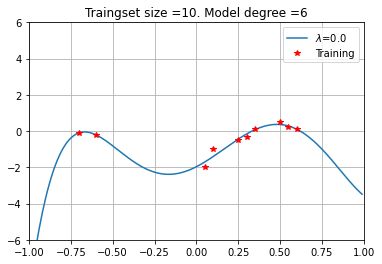

In [5]:
plt.plot(x_test_list, y_hat_list, label=r"$\lambda$=0.0")
plt.plot(x_train, y_train, "r*", label="Training")
plt.title("Traingset size ={}. Model degree ={}".format(len(x_train), model_degree))
plt.legend()
plt.grid()
plt.xlim(-1, 1)
plt.ylim(-6, 6)
plt.show()

In [38]:
def calc_regret_single(x_arr_train, y_vec, x_vec_test, svd_res, epsilon_n, var=1):
    N, M = x_arr_train.shape
    u, s, vh = svd_res
    s_inv = 1 / (s + lamb)

    s_inv[s_inv == inf] = 0

    # Cacl
    P = u @ np.diag(s_inv) @ vh
    x_t_P_x = float(x_vec_test.T @ P @ x_vec_test)
    K0 = 1 + x_t_P_x

    return np.log(K0)


def calc_regret_series(x_arr_train, y_vec, x_vec_test, svd_res, epsilon_n, var=1):
    N, M = x_arr_train.shape
    u, s, vh = svd_res
    s_inv = 1 / (s + lamb)

    s_inv[s_inv == inf] = 0

    # Cacl
    P = u @ np.diag(s_inv) @ vh
    x_t_P_x = float(x_vec_test.T @ P @ x_vec_test)
    K0 = 1 + x_t_P_x

    X_N_P_x = (x_arr_train @ P @ x_vec_test).squeeze()
    
    var = np.mean(epsilon_n ** 2)
    a1 = -1 / (2 * var) * np.sum(epsilon_n ** 2)
    a2 = 0.5 * np.log(K0)

    a3 = -0.5 * N * np.log(2 * np.pi * var)

    return a1 + a2 + a3, {"a1": a1, "a2": a2, "a3": a3}


phi_train = data_h.phi_train
rank = min(phi_train.shape)
(h, s, vh) = npl.svd(phi_train.T @ phi_train, hermitian=True)
s[rank:] = 0
svd_res = h, s, vh
y_vec = np.array([y_train])
epsilon_n = y_train - (phi_train @ theta_erm).squeeze()

var = np.mean(epsilon_n ** 2)
regrets_series, regret_single, res_dicts = [], [], []
for x_test in tqdm(x_test_list):
    phi_test = data_h.convert_point_to_features(x_test, model_degree)

    y_vec = np.array([y_train])

    regret, res_dict = calc_regret_series(
        phi_train, y_train, phi_test, svd_res, epsilon_n
    )
    regrets_series.append(regret)
    res_dicts.append(res_dict)

    regret = calc_regret_single(phi_train, y_train, phi_test, svd_res, epsilon_n)
    regret_single.append(regret)

  0%|          | 0/200 [00:00<?, ?it/s]

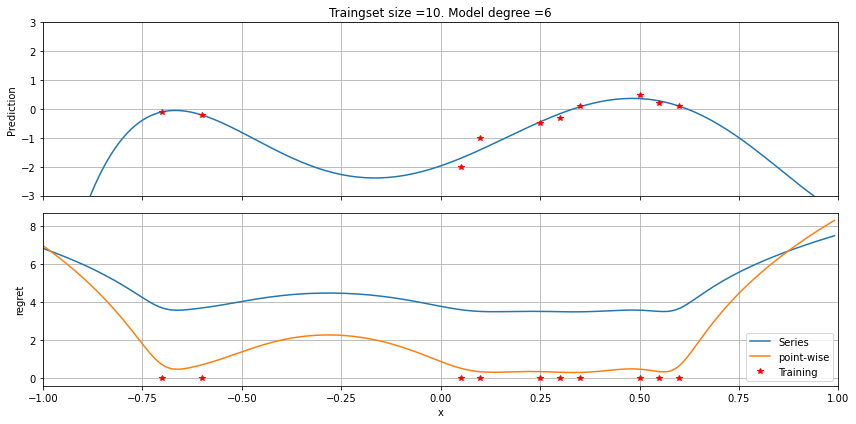

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax = axs[0]
ax.plot(x_test_list, y_hat_list, label="ERM")
ax.plot(x_train, y_train, "r*", label="Training")

ax.set_title("Traingset size ={}. Model degree ={}".format(len(x_train), model_degree))
ax.set_ylabel("Prediction")
ax.grid(True)
ax.set_xlim(-1, 1)
ax.set_ylim(-3, 3)

ax = axs[1]
ax.plot(x_test_list, regrets_series, label="Series")
ax.plot(x_test_list, regret_single, label="point-wise")
ax.plot(x_train, [0] * len(x_train), "r*", label="Training")

ax.set_ylabel(r"regret")
ax.set_xlabel("x")
# ax.set_ylim(bottom=0.0)
ax.legend()
ax.grid(True)


plt.tight_layout()
plt.show()

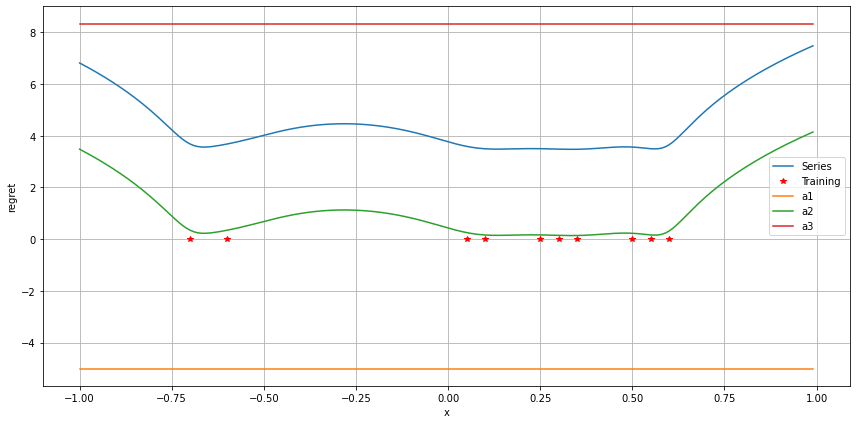

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

ax = axs

ax.plot(x_test_list, regrets_series, label="Series")
ax.plot(x_train, [0] * len(x_train), "r*", label="Training")


keys = list(res_dicts[0].keys())
for key in keys:
    ax.plot(x_test_list, [res_dict[key] for res_dict in res_dicts], label=key)

ax.set_ylabel(r"regret")
ax.set_xlabel("x")
# ax.set_ylim(bottom=0.0)
ax.legend()
ax.grid(True)


plt.tight_layout()
plt.show()

In [34]:
np.max([res_dict["a3"] for res_dict in res_dicts])

0